# RNN Lab - Sentiment Classification

In [1]:
# importing relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download(["stopwords", "punkt", "wordnet"])
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Embedding,Dropout, Conv1D,MaxPooling1D,GlobalAveragePooling1D, SimpleRNN,SpatialDropout1D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import kerastuner as kt
from tensorflow import keras

import nlpaug.augmenter.word as naw


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-01-11 11:21:26.335380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 11:21:26.335485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 11:21:26.448722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

#### Loading data

In [2]:
data = pd.read_csv("../Lab_RNN/Data/emotions.csv") # creating data frame from the csv file

data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [3]:
data.value_counts # using value count to count how many rows in data frame

<bound method DataFrame.value_counts of                                                     text    label
0      i feel so pissed off over an old friend and so...    anger
1      ive found it has made a huge difference especi...    anger
2      i also feel it is unfortunate that nearly all ...  sadness
3                       i feel petty a href http clairee    anger
4      i used to believe that a feeling like fear was...  sadness
...                                                  ...      ...
19995  i was i might be buying stuff from there but i...      joy
19996  i like sonam deepika and genelia who i feel ar...      joy
19997  i feel pathetic that i can hardly go a whole d...  sadness
19998  id have spent more time with her on reading i ...  sadness
19999  i do however feel like one of those pathetic g...  sadness

[20000 rows x 2 columns]>

In [4]:
# Checking for any null values
data.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
duplicates =data[data.duplicated]
print(f"Duplicates {duplicates}")

Duplicates                                                    text label
6154  i feel more adventurous willing to take risks ...   joy


In [6]:
# remove duplicates
data = data.drop_duplicates()

The data set contains 20,000 rows of text lines then classed with an emotion.

<Axes: xlabel='label'>

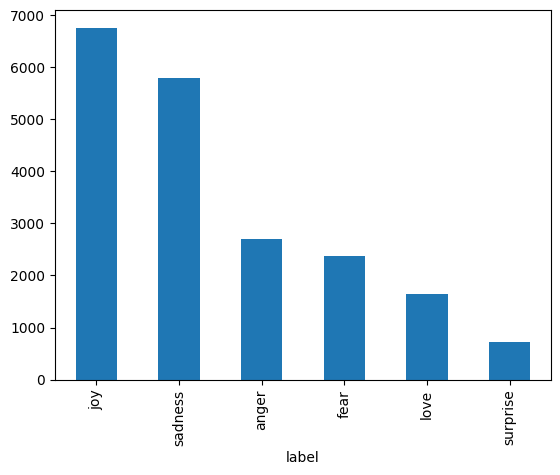

In [7]:
data.label.value_counts().plot.bar() 

Here we can see that the data set is not very equal across all catagories. This may make the training more biased to certain emotions like joy and sadness. We also see that there is six different catagories for the emotions.

In [9]:
joy = data[data["label"]== "joy"]
sadness = data[data["label"]== "sadness"]
anger = data[data["label"]== "anger"]
fear = data[data["label"] == "fear"]
love = data[data["label"] == "love"]
surprise = data[data["label"] == "surprise"]

love = love.sample(n=len(surprise), random_state=42)
fear = fear.sample(n=len(surprise), random_state=42)
anger = anger.sample(n=len(surprise), random_state=42)
sadness = sadness.sample(n=len(surprise), random_state=42)
joy = joy.sample(n=len(surprise), random_state=42)

data = pd.concat([joy,sadness,anger,fear,love,surprise], axis=0)

In [10]:
data.head()

,text,label
17713,i feel so glad that im able to have the time t...,joy
14436,i could look up the coordinates of the cave bu...,joy
8631,i need you i need someone i need to be protect...,joy
6740,i can t imagine a real life scenario where i w...,joy
1381,im feeling very optimistic about it and find m...,joy


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, 17713 to 19949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4314 non-null   object
 1   label   4314 non-null   object
dtypes: object(2)
memory usage: 101.1+ KB


<Axes: xlabel='label'>

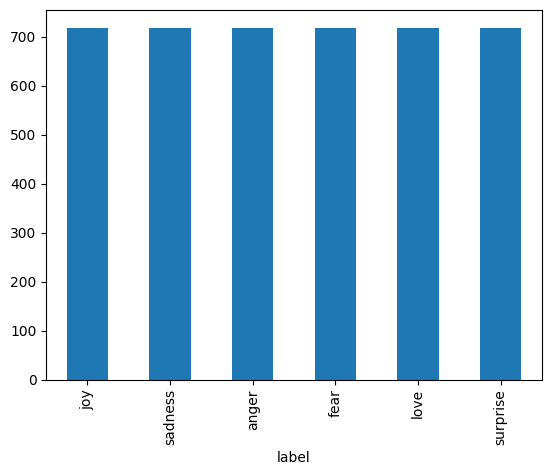

In [12]:
data.label.value_counts().plot.bar() 

In [14]:
def augment_with_emotion(row, aug):
    original_text = row['text']
    original_emotion = row['label']
    
    augmented_text = aug.augment(original_text)
    
    # Create a new row with augmented text and the original emotion label
    row["text"] = augmented_text
    row["label"] = original_emotion
    
    return row

# Augmenter configuration
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Apply the augmentation function to each row in the DataFrame
augmented_df = data.apply(lambda row: augment_with_emotion(row, aug), axis=1)

augmented_df

,text,label
17713,[now i feel so glad that im is able to have th...,joy
14436,[hopefully i could look directly up into the c...,joy
8631,[i need you amy i need someone i need to would...,joy
6740,[i can u t imagine a real life scenario scenar...,joy
1381,[but im feeling very optimistic about it and s...,joy
...,...,...
19890,[now i never go easily around people and i act...,surprise
19901,[and i definitely feel herpes coming i would b...,surprise
19915,[and i like it to often do things that leave o...,surprise
19944,[and i feel like a monster because as together...,surprise


In [14]:
augmented_df.to_csv("../Lab_RNN/Data/augmented.csv")

NameError: name 'augmented_df' is not defined

In [13]:
augmented_df= pd.read_csv("../Lab_RNN/Data/augmented.csv")
augmented_df

,Unnamed: 0,text,label
0,0,['now i feel so glad that im is able to have t...,joy
1,1,['hopefully i could look directly up into the ...,joy
2,2,['i need you amy i need someone i need to woul...,joy
3,3,['i can u t imagine a real life scenario scena...,joy
4,4,['but im feeling very optimistic about it and ...,joy
...,...,...,...
4309,4309,['now i never go easily around people and i ac...,surprise
4310,4310,['and i definitely feel herpes coming i would ...,surprise
4311,4311,['and i like it to often do things that leave ...,surprise
4312,4312,['and i feel like a monster because as togethe...,surprise


In [14]:
augmented_df = augmented_df.drop("Unnamed: 0", axis=1)
augmented_df

,text,label
0,['now i feel so glad that im is able to have t...,joy
1,['hopefully i could look directly up into the ...,joy
2,['i need you amy i need someone i need to woul...,joy
3,['i can u t imagine a real life scenario scena...,joy
4,['but im feeling very optimistic about it and ...,joy
...,...,...
4309,['now i never go easily around people and i ac...,surprise
4310,['and i definitely feel herpes coming i would ...,surprise
4311,['and i like it to often do things that leave ...,surprise
4312,['and i feel like a monster because as togethe...,surprise


In [15]:
augmented_df['text'] = augmented_df['text'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

In [16]:
data = pd.concat([data, augmented_df], ignore_index=True)
data

,text,label
0,i feel so glad that im able to have the time t...,joy
1,i could look up the coordinates of the cave bu...,joy
2,i need you i need someone i need to be protect...,joy
3,i can t imagine a real life scenario where i w...,joy
4,im feeling very optimistic about it and find m...,joy
...,...,...
8623,now i never go easily around people and i act ...,surprise
8624,and i definitely feel herpes coming i would be...,surprise
8625,and i like it to often do things that leave ot...,surprise
8626,and i feel like a monster because as together ...,surprise


<Axes: xlabel='label'>

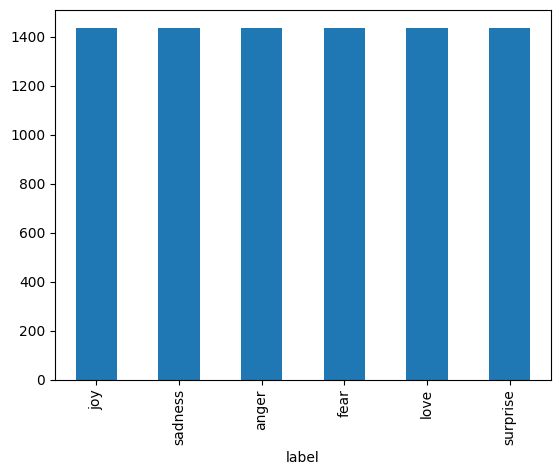

In [17]:
data.label.value_counts().plot.bar() 

#### Preprocessing

In [18]:
data['text'] = data['text'].astype(str)
data['label'] = data['label'].astype(str)

In [19]:
data.loc[:, "text"] = data["text"].str.lower().str.replace('[\[\]"\']','') # convert text to lowercase and remove square brackets and quotation marks
data.loc[:, "label"] = data["label"].str.lower().str.replace('[^\w\s"\'\[\]]','')


In [20]:
data

,text,label
0,i feel so glad that im able to have the time t...,joy
1,i could look up the coordinates of the cave bu...,joy
2,i need you i need someone i need to be protect...,joy
3,i can t imagine a real life scenario where i w...,joy
4,im feeling very optimistic about it and find m...,joy
...,...,...
8623,now i never go easily around people and i act ...,surprise
8624,and i definitely feel herpes coming i would be...,surprise
8625,and i like it to often do things that leave ot...,surprise
8626,and i feel like a monster because as together ...,surprise


In [159]:
data.to_csv("../Lab_RNN/Data/new_data.csv")

In [44]:
# testing original data
original_data = pd.read_csv("../Lab_RNN/Data/emotions.csv")
original_data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [21]:
# create a preproccessing function that will process the text column

def preprocess_text(text):
    
    # convert text to lowercase
    text = text.lower()

    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text



In [45]:
original_data.loc[:, "text"] = original_data["text"].apply(preprocess_text)
original_data.head()

,text,label
0,feel pissed old friend friend,anger
1,ive found made huge difference especially fing...,anger
2,also feel unfortunate nearly reader going meet...,sadness
3,feel petty href http clairee,anger
4,used believe feeling like fear ignored suppres...,sadness


In [46]:
pd.Series(original_data["text"]).str.len().describe()

count    20000.000000
mean        60.805300
std         34.518619
min          4.000000
25%         34.000000
50%         54.000000
75%         80.000000
max        229.000000
Name: text, dtype: float64

In [22]:
data.loc[:, "text"] = data["text"].apply(preprocess_text)
data

,text,label
0,feel glad im able time spend time family,joy
1,could look coordinate cave im feeling adventur...,joy
2,need need someone need protected feel safe sma...,joy
3,imagine real life scenario would emotionally c...,joy
4,im feeling optimistic find wanting ride,joy
...,...,...
8623,never go easily around people act normal someh...,surprise
8624,definitely feel herpes coming would slightly s...,surprise
8625,like often thing leave others feeling genuinel...,surprise
8626,feel like monster together make way silently r...,surprise


In [23]:
# checking the length of the strings so that i have an idea of how long i should make the max words in the sequence length for padding
print(pd.Series(data["text"]).str.len().mean())
print(pd.Series(data["text"]).str.len().max())

74.38769123783032
282


This gives a rough idea that every string has an average of 74 words and that the longest sentence has 229 words. I can use a box plot to see more clearly

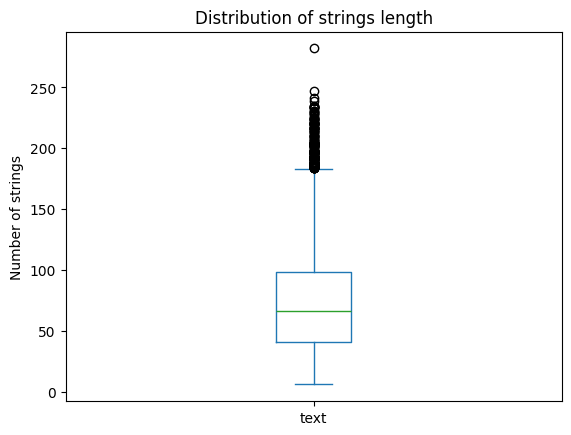

count    8628.000000
mean       74.387691
std        42.883268
min         6.000000
25%        41.000000
50%        66.000000
75%        98.000000
max       282.000000
Name: text, dtype: float64

In [24]:
strings_len = pd.Series(data["text"]).str.len()

strings_len.plot.box()
plt.title("Distribution of strings length")
plt.ylabel("Number of strings")
plt.show()

strings_len.describe()

You can see most strings are up to 150 words. But with using the describe function on the length of the strings we can see that around 75 % of the comments are up to 98 words long. This will be taken into account when padding. Some sentences may be shorter so they will need to have padding. This is an important stage as we need to decide how many relevant words of the text should be processed within the model. If we use too many the training process will be longer. We can see on the box plot that most of the text lengths are between the 40 to 100 range. So I think it is reasonable to have the input length at 80.    

#### Preparing text to be used with Deep learning model

I will now tokenize the text and pad it. I will also one hot code the labels.

In [25]:
# encoding emotions
encoded_emotions = {
    "anger" : 0,
    "fear": 1,
    "joy" : 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

data.replace(encoded_emotions, inplace = True)
data.head()

,text,label
0,feel glad im able time spend time family,2
1,could look coordinate cave im feeling adventur...,2
2,need need someone need protected feel safe sma...,2
3,imagine real life scenario would emotionally c...,2
4,im feeling optimistic find wanting ride,2


In [47]:
original_data.replace(encoded_emotions, inplace = True)
original_data.head()

,text,label
0,feel pissed old friend friend,0
1,ive found made huge difference especially fing...,0
2,also feel unfortunate nearly reader going meet...,4
3,feel petty href http clairee,0
4,used believe feeling like fear ignored suppres...,4


In [105]:
X2_train, X2_test, y2_train, y2_test = train_test_split(original_data["text"], original_data["label"], test_size=0.2, random_state=42)

X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.25, random_state=42)

print(f"X_train = {X2_train.shape} and y_train = {y2_train.shape}")
print(f"X_test = {X2_test.shape} and y_test = {y2_test.shape}")
print(f"X_val = {X2_val.shape} and y_val = {y2_val.shape}")

X_train = (12000,) and y_train = (12000,)
X_test = (4000,) and y_test = (4000,)
X_val = (4000,) and y_val = (4000,)


In [48]:
# Splitting the data into train, val and test before toeknization and padding
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"X_train = {X_train.shape} and y_train = {y_train.shape}")
print(f"X_test = {X_test.shape} and y_test = {y_test.shape}")
print(f"X_val = {X_val.shape} and y_val = {y_val.shape}")



X_train = (5176,) and y_train = (5176,)
X_test = (1726,) and y_test = (1726,)
X_val = (1726,) and y_val = (1726,)


<class 'pandas.core.series.Series'>
Index: 5176 entries, 8345 to 4880
Series name: label
Non-Null Count  Dtype
--------------  -----
5176 non-null   int64
dtypes: int64(1)
memory usage: 80.9 KB


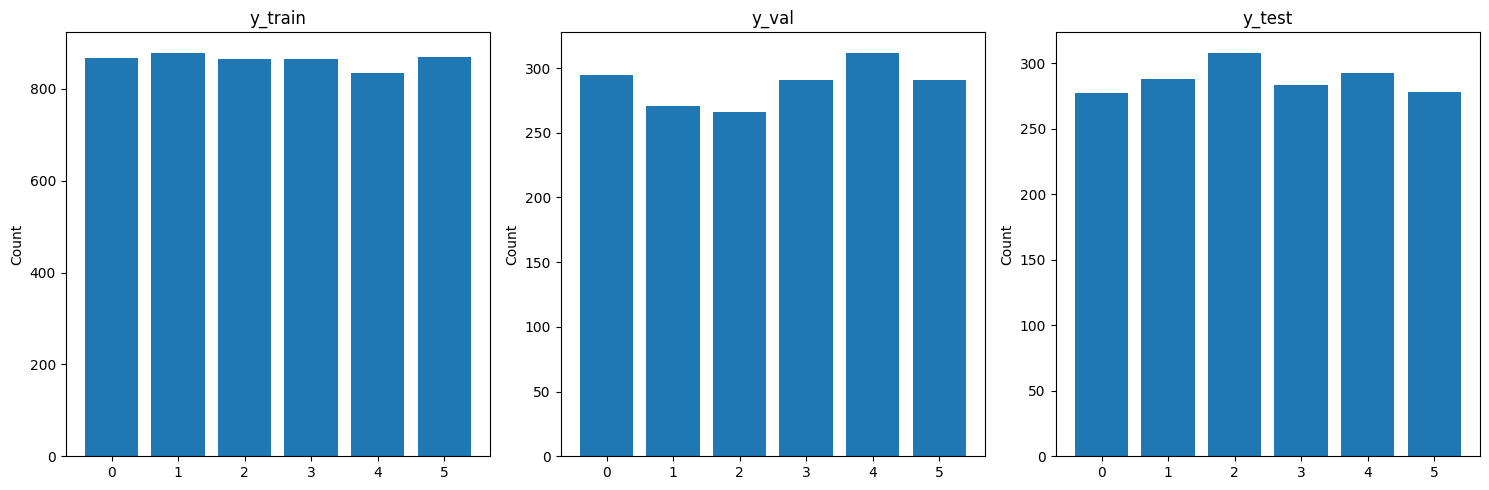

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for y_train
axs[0].bar(y_train.value_counts().index, y_train.value_counts())
axs[0].set_title('y_train')
axs[0].set_ylabel('Count')

# Plot for y_val
axs[1].bar(y_val.value_counts().index, y_val.value_counts())
axs[1].set_title('y_val')
axs[1].set_ylabel('Count')

# Plot for y_test
axs[2].bar(y_test.value_counts().index, y_test.value_counts())
axs[2].set_title('y_test')
axs[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [51]:
# Tokenize the text data

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.astype(str))

X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(tokenizer.word_index)

for i in range (10):
    print(f"Sequence {i + 1}: {X_train_seq[i]}")


6759
{'feel': 1, 'feeling': 2, 'like': 3, 'im': 4, 'really': 5, 'even': 6, 'still': 7, 'little': 8, 'time': 9, 'know': 10, 'also': 11, 'make': 12, 'people': 13, 'always': 14, 'one': 15, 'actually': 16, 'would': 17, 'get': 18, 'day': 19, 'thing': 20, 'think': 21, 'bit': 22, 'want': 23, 'ive': 24, 'life': 25, 'something': 26, 'much': 27, 'back': 28, 'sometimes': 29, 'love': 30, 'could': 31, 'going': 32, 'though': 33, 'need': 34, 'today': 35, 'way': 36, 'dont': 37, 'never': 38, 'go': 39, 'pretty': 40, 'right': 41, 'around': 42, 'ever': 43, 'say': 44, 'almost': 45, 'good': 46, 'overwhelmed': 47, 'friend': 48, 'year': 49, 'strange': 50, 'weird': 51, 'well': 52, 'often': 53, 'quite': 54, 'work': 55, 'help': 56, 'see': 57, 'many': 58, 'suddenly': 59, 'amazed': 60, 'cant': 61, 'someone': 62, 'didnt': 63, 'sure': 64, 'made': 65, 'new': 66, 'probably': 67, 'come': 68, 'enough': 69, 'completely': 70, 'already': 71, 'somehow': 72, 'look': 73, 'thought': 74, 'maybe': 75, 'le': 76, 'last': 77, 'firs

In [106]:
max_words = 11591
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X2_train.astype(str))

X2_train_seq = tokenizer.texts_to_sequences(X2_train.astype(str))
X2_val_seq = tokenizer.texts_to_sequences(X2_val.astype(str))
X2_test_seq = tokenizer.texts_to_sequences(X2_test.astype(str))


vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(tokenizer.word_index)

for i in range (10):
    print(f"Sequence {i + 1}: {X2_train_seq[i]}")

11591
{'feel': 1, 'feeling': 2, 'like': 3, 'im': 4, 'time': 5, 'really': 6, 'know': 7, 'get': 8, 'make': 9, 'little': 10, 'people': 11, 'day': 12, 'want': 13, 'thing': 14, 'would': 15, 'one': 16, 'think': 17, 'life': 18, 'still': 19, 'even': 20, 'ive': 21, 'way': 22, 'love': 23, 'bit': 24, 'dont': 25, 'going': 26, 'something': 27, 'much': 28, 'could': 29, 'go': 30, 'back': 31, 'need': 32, 'good': 33, 'pretty': 34, 'see': 35, 'say': 36, 'right': 37, 'always': 38, 'year': 39, 'friend': 40, 'today': 41, 'also': 42, 'made': 43, 'around': 44, 'work': 45, 'help': 46, 'though': 47, 'cant': 48, 'got': 49, 'come': 50, 'lot': 51, 'thought': 52, 'well': 53, 'someone': 54, 'didnt': 55, 'week': 56, 'many': 57, 'le': 58, 'felt': 59, 'look': 60, 'quite': 61, 'never': 62, 'every': 63, 'happy': 64, 'sure': 65, 'anything': 66, 'kind': 67, 'away': 68, 'find': 69, 'left': 70, 'take': 71, 'enough': 72, 'without': 73, 'home': 74, 'person': 75, 'last': 76, 'better': 77, 'everything': 78, 'http': 79, 'world':

In [52]:
max_sequence_length = 100

X_train = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post")
X_val = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
X_test = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

for i in range (3):
    print(f"Sequence{i +1}: {X_train[i]}")


Sequence1: [   1    3 4480  132  790 2791   32 4481 2212 2791   32 4482 4483 2792
   77   49 2213    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Sequence2: [ 189   61   12 2214  791 1226  373    1  525    8   66   20    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

In [110]:
max_sequence_length = 50

X2_train = pad_sequences(X2_train_seq, maxlen=max_sequence_length, padding="post")
X2_val = pad_sequences(X2_val_seq, maxlen=max_sequence_length, padding="post")
X2_test = pad_sequences(X2_test_seq, maxlen=max_sequence_length, padding="post")

for i in range (3):
    print(f"Sequence{i +1}: {X2_train[i]}")

Sequence1: [  1 228 107   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sequence2: [1424 5649  519 5650 1736 3202 5651 2101   43 1736 3202  253  169 1520
 1737  208    2    1  170  138  138 1889  734   44  192  163 1521   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Sequence3: [1038    9  186  895    9    1  311    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [66]:
X_train

array([[   1,    3, 4480, ...,    0,    0,    0],
       [ 189,   61,   12, ...,    0,    0,    0],
       [  33,   67,   44, ...,    0,    0,    0],
       ...,
       [   4,   47,    2, ...,    0,    0,    0],
       [1911, 1013,  145, ...,    0,    0,    0],
       [ 543,  183, 6758, ...,    0,    0,    0]], dtype=int32)

# converting to Tensorflow tensors for the model
X_train_tensor = tf.constant(X__train_padded, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))

X_val_tensor = tf.constant(X_val_padded, dtype=tf.int32)
y_val_tensor = tf.constant(y_val, dtype=tf.int32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))

print(train_dataset)
print(val_dataset)

### Designing a model

I will now design a model. I will use the Long Short-Term Memory(LSTM) type of RNN model as it handles stochastic gradient failure better than a regular RNN. It can handle longer sequences better. I will start by creating a simple network with one LTSM layer to see how the  model performs.

I will use the following formula to determine the number of nodes within the layer: 

$ N_i = \frac{2}{3} * (N_i + N_o) $

$N_i$ is equal to the number of input words
$N_o$ is equal to number of output neurons

This will give me a basic idea on what number of nodes to begin with then I can adjust after training the model. 

I will also include a Dropout layer to help reduce in overfitting. This will randomly ignore selected neurons during training and reduce the sensitivity of specific weights. I have chosen 0.2 as my starting point as it is a good compromise in retaining accuracy and overfitting.

I will use the softmax activation function in my activation layer as it will interpret the outputs as probabilities for each class.

The model I will build will be simple to begin then it will be built upon by testing different hyperparemters with the keras tuner

In [54]:
hidden_nodes = int(2/3 * (max_sequence_length * 6))
print(f"The number of hidden nodes is: {hidden_nodes}")

The number of hidden nodes is: 400


In [55]:
y_val

1786    0
6541    1
4318    2
2710    1
1238    4
       ..
4328    2
1487    0
5144    4
5874    0
1165    4
Name: label, Length: 1726, dtype: int64

In [111]:
def train_and_evaluate_model(epochs, checkpoint_filepath):
    
    model= Sequential()
    model.add(Embedding(11591, 64, input_length=50))
    # add max pooling
    # add conv 1d
    #model.add(Conv1D(filters=128, kernel_size = 3, padding="same",activation="relu"))
    #model.add(MaxPooling1D(pool_size=5))
    #model.add(Dropout(0.4))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.5))
    #model.add(LSTM(50, return_sequences=True)) # kernel_regularizer=keras.regularizers.l2(0.001))) 
    model.add(LSTM(10,return_sequences=True))
    #model.add(SpatialDropout1D(0.2))
    #model.add(SimpleRNN(100,return_sequences=True))
    model.add(LSTM(10,return_sequences=True))
    #model.add(SimpleRNN(100,return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=True))
    #model.add(SimpleRNN(100,return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    #model.add(Dense(1000, activation="relu"))
    #model.add(Dense(400, activation="relu"))
    #model.add(Dense(100, activation="relu"))
    #model.add(Dense(50, activation="relu"))
    model.add(Dense(100, activation="relu")) #100 
    #model.add(Dense(64, activation="tanh")) 50
    #Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5,kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    #model = Sequential([
    #keras.layers.Embedding(10000, 64), # exact number of words in dataset
    #Conv1D(32, 7, activation='relu'),
    #MaxPooling1D(5),
    #Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    #Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    #keras.layers.Dense(6, activation='sigmoid')
#])

    #model.compile(loss="categorical_cross", optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=["accuracy"])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True

    #reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2)
    )

    history = model.fit(X2_train, y2_train, 
                        validation_data=(X2_val,y2_val), 
                        epochs=epochs,batch_size=64, 
                        callbacks=[early_stopping, model_checkpoint]) 

    test_loss, test_accuracy = model.evaluate(X2_test, y2_test, verbose=0) # test data results when run through the model
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #visualizing training and validation results
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())

    best_model = load_model(checkpoint_filepath)
    
    return best_model


Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 1.6005 - accuracy: 0.3316
Epoch 1: val_accuracy improved from -inf to 0.33900, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 35s 155ms/step - loss: 1.6005 - accuracy: 0.3316 - val_loss: 1.5856 - val_accuracy: 0.3390
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.3353
Epoch 2: val_accuracy did not improve from 0.33900
188/188 [==============================] - 20s 104ms/step - loss: 1.5743 - accuracy: 0.3353 - val_loss: 1.5825 - val_accuracy: 0.3390
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 1.2768 - accuracy: 0.4066
Epoch 3: val_accuracy improved from 0.33900 to 0.42525, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 30s 159ms/step - loss: 1.2768 - accuracy: 0.4066 - val_loss: 1.2146 - val_accuracy: 0.4252
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.4492
Epoch 4: val_accuracy improved from 0.42525 to 0.44325, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 31s 163ms/step - loss: 1.0671 - accuracy: 0.4492 - val_loss: 1.1161 - val_accuracy: 0.4433
Epoch 5/50
188/188 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.4922
Epoch 5: val_accuracy improved from 0.44325 to 0.48700, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 29s 154ms/step - loss: 0.9623 - accuracy: 0.4922 - val_loss: 1.0697 - val_accuracy: 0.4870
Epoch 6/50
188/188 [==============================] - ETA: 0s - loss: 0.8057 - accuracy: 0.5889
Epoch 6: val_accuracy improved from 0.48700 to 0.56075, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 30s 159ms/step - loss: 0.8057 - accuracy: 0.5889 - val_loss: 1.0142 - val_accuracy: 0.5608
Epoch 7/50
188/188 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.6335
Epoch 7: val_accuracy improved from 0.56075 to 0.58275, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 31s 166ms/step - loss: 0.7071 - accuracy: 0.6335 - val_loss: 0.9539 - val_accuracy: 0.5828
Epoch 8/50
188/188 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6395
Epoch 8: val_accuracy improved from 0.58275 to 0.59175, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 29s 153ms/step - loss: 0.6578 - accuracy: 0.6395 - val_loss: 0.9630 - val_accuracy: 0.5918
Epoch 9/50
188/188 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.6432
Epoch 9: val_accuracy did not improve from 0.59175
188/188 [==============================] - 21s 112ms/step - loss: 0.6503 - accuracy: 0.6432 - val_loss: 0.9411 - val_accuracy: 0.5890
Epoch 10/50
188/188 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.6600
Epoch 10: val_accuracy improved from 0.59175 to 0.61125, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 30s 162ms/step - loss: 0.6066 - accuracy: 0.6600 - val_loss: 0.9210 - val_accuracy: 0.6112
Epoch 11/50
188/188 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.6783
Epoch 11: val_accuracy did not improve from 0.61125
188/188 [==============================] - 21s 112ms/step - loss: 0.5679 - accuracy: 0.6783 - val_loss: 0.9608 - val_accuracy: 0.6095
Epoch 12/50
188/188 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.6806
Epoch 12: val_accuracy improved from 0.61125 to 0.61225, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 30s 158ms/step - loss: 0.5663 - accuracy: 0.6806 - val_loss: 0.9481 - val_accuracy: 0.6122
Epoch 13/50
188/188 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.6885
Epoch 13: val_accuracy improved from 0.61225 to 0.62150, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 32s 170ms/step - loss: 0.5462 - accuracy: 0.6885 - val_loss: 0.9107 - val_accuracy: 0.6215
Epoch 14/50
188/188 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.6865
Epoch 14: val_accuracy did not improve from 0.62150
188/188 [==============================] - 20s 107ms/step - loss: 0.5391 - accuracy: 0.6865 - val_loss: 0.9405 - val_accuracy: 0.6173
Epoch 15/50
188/188 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.6829
Epoch 15: val_accuracy did not improve from 0.62150
188/188 [==============================] - 20s 104ms/step - loss: 0.5496 - accuracy: 0.6829 - val_loss: 0.8847 - val_accuracy: 0.6202
Epoch 16/50
188/188 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.6809
Epoch 16: val_accuracy improved from 0.62150 to 0.62375, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 33s 179ms/step - loss: 0.5283 - accuracy: 0.6809 - val_loss: 0.8792 - val_accuracy: 0.6237
Epoch 17/50
188/188 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.6870
Epoch 17: val_accuracy did not improve from 0.62375
188/188 [==============================] - 21s 113ms/step - loss: 0.5263 - accuracy: 0.6870 - val_loss: 0.9721 - val_accuracy: 0.6012
Epoch 18/50
188/188 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.6852
Epoch 18: val_accuracy did not improve from 0.62375
188/188 [==============================] - 21s 114ms/step - loss: 0.5414 - accuracy: 0.6852 - val_loss: 1.0327 - val_accuracy: 0.5945
Epoch 19/50
188/188 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.6867
Epoch 19: val_accuracy did not improve from 0.62375
188/188 [==============================] - 20s 108ms/step - loss: 0.5460 - accuracy: 0.6867 - val_loss: 0.9399 - val_accuracy: 0.5642
Epoch 19: early s

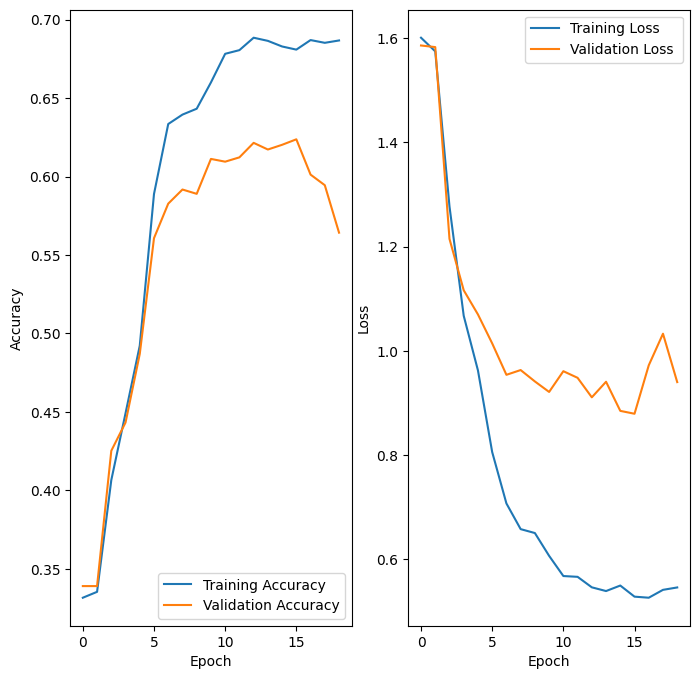

In [112]:
train_and_evaluate_model(50, "../Lab_RNN/model_save")

As We can see see this model was not successful at all! I think the model needs to have some more layers. I will now test out keras tuner to test more than one layer and to see which hyper parameters may be more effective. 

In [ ]:
def model_builder(hp):
    model= Sequential()
    model.add(Embedding(20000, 
                        hp.Int("embedding_size", min_value=32, max_value=256, step=32), 
                        input_length=80))
    model.add(LSTM(units= hp.Int("LSTM_units", min_value= 32, max_value=256, step = 32)))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 64, max_value=512, step=64),
                    activation="relu"))
    model.add(Dropout(rate=hp.Choice("dropout", values=[0.2,0.3,0.4,0.5])))
    model.add(Dense(6, activation="softmax"))

    model.compile(
    optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

    return model

    

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', # which parameter to observe
                     max_epochs=10,
                     factor=3, #the reduction factor, The smaller it is the more aggressive reduction in configurations
                     directory='tuner_results_RNN', # results saved to a directory
                     project_name='sentiment')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) # early stopping used when better parameters are found to save time in tuning

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping]) # The training search

Trial 30 Complete [00h 06m 56s]
val_accuracy: 0.3407500088214874

Best val_accuracy So Far: 0.3407500088214874
Total elapsed time: 02h 11m 07s


In [ ]:
best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

# prints out best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 224)           4480000   
                                                                 
 lstm (LSTM)                 (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 320)               82240     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 5056710 (19.29 MB)
Trainable params: 5056710 (19.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'embedding

I had a problem with saving the parameters to file. SO i copied the results above just incase I could not retrieve them.

```Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, 80, 224)           4480000   
                                                                 
 lstm (LSTM)                 (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 320)               82240     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
=================================================================
Total params: 5056710 (19.29 MB)
Trainable params: 5056710 (19.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'embedding_size': 224, 'LSTM_units': 256, 'Dense_units': 320, 'dropout': 0.5, 'learning_rate': 0.01, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Trial 30 Complete [00h 06m 56s]
val_accuracy: 0.3407500088214874

Best val_accuracy So Far: 0.3407500088214874
Total elapsed time: 02h 11m 07s
```


In [ ]:
tuner_hyper = {
    "embed": 224,
    "LSTM1_units" : 256,
    "LSTM2_units" : 256,
    "Dense1_units" : 320,
    "Dense2_units" : 160,
    "dropout" : 0.5,
    "learning_rate" : 0.01


}

In [ ]:
def tuner_model(epochs, checkpoint_filepath,hyperparemeters=None):

    if hyperparemeters is None:
        hyperparemeters = tuner_hyper
    
    model= Sequential()
    model.add(Embedding(input_dim= 20000, output_dim=hyperparemeters["embed"], input_length=80))
    model.add(LSTM(units=hyperparemeters["LSTM1_units"], return_sequences=True))
    model.add(LSTM(units=hyperparemeters["LSTM2_units"],return_sequences=False))
    model.add(Dense(units=hyperparemeters["Dense1_units"], activation="relu"))
    model.add(Dense(units=hyperparemeters["Dense2_units"]))
    model.add(Dropout(rate=hyperparemeters["dropout"]))
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=hyperparemeters["learning_rate"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True
    )

    # fitting the model to the training model to train
    history = model.fit(X_train,y_train , epochs=epochs, validation_data=(X_val,y_val), callbacks=[early_stopping, model_checkpoint])

    # evaluating the model with the test dataset
    test_loss, test_accuracy =model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # plotting the validation loss and training accuracy
    plt.figure(figsize=(8,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return best_model
    

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 1.6170 - accuracy: 0.3239
Epoch 1: val_accuracy improved from -inf to 0.34075, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


375/375 [==============================] - 246s 647ms/step - loss: 1.6170 - accuracy: 0.3239 - val_loss: 1.5886 - val_accuracy: 0.3408
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.3280
Epoch 2: val_accuracy did not improve from 0.34075
375/375 [==============================] - 235s 627ms/step - loss: 1.5854 - accuracy: 0.3280 - val_loss: 1.5853 - val_accuracy: 0.3408
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 1.5852 - accuracy: 0.3243
Epoch 3: val_accuracy did not improve from 0.34075
375/375 [==============================] - 234s 623ms/step - loss: 1.5852 - accuracy: 0.3243 - val_loss: 1.5841 - val_accuracy: 0.3408
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.3302
Epoch 4: val_accuracy did not improve from 0.34075
375/375 [==============================] - 234s 625ms/step - loss: 1.5859 - accuracy: 0.3302 - val_loss: 1.5844 - val_accuracy: 0.3408
Epoch 5/50
375/375 

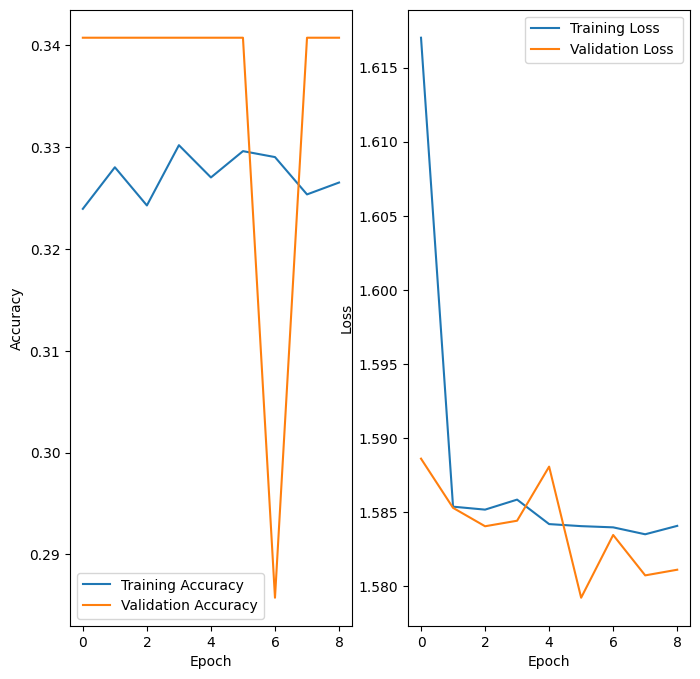

In [ ]:
tuner_model(50, "../Lab_RNN/model_save",None)